# ICPE 689 Data Science Fundamental for Energy II

Some of the examples and exercises of this course are based on two popular books on data science with Python, [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)
and [the Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/).

<span><img src="images/HandsonML.jpg" width="200" /><img src="images/PDSH-cover.png" width="200" /></span>

## Dimension Reduction Methods

This modcule covers the process to transform data from a high-dimensional space into a low-dimensional space so that the low-dimensional representation retains some meaningful properties of the original data, ideally close to its intrinsic dimension. This process is called dimensionality reduction. The space of the new features is also called the projection space. We will cover 2 commonly used dimensionality reduction methods.

1. Principal Component Analysis (PCA)
2. T-SNE

[<img src="images/colab-badge.png" width="200"/>](https://colab.research.google.com/github/jtao/AdvancedML/blob/main/Dimension_Reduction_methods.ipynb)

### Curse of Dimensionality
Most traditional machine learning methods break down in high dimensions, and this phenomenon is commonly referred to as the curse
of dimensionality. The reason for this phenomenon is shown in the following discussion.

> Consider a p-dimensional unit hypercube $[0,1]^p$ whose volume is 1. For a given target point, the volume of the hypercubical neighborhood of this point with the edge length $r$ is $S = r^d$. Then if we uniformly sample $N$ observations from it, to include a fraction S of the observations in the hypercubical neighborhood of a target point, the expected edge length will be $e_p(r) = S^{1/p}$.

* When $p=10$ and $S = 0.1$, $e_{10}(r) \approx 0.80$. Recall that the entire range for each dimension is only 1, it means that to capture 10% of the data to form a local average, we must cover 80% of the range of each input variable. **Such neighborhoods are no longer “local.”**
* Another manifestation is that, when $p$ is big, the sampling density is proportional to $N^{1/p}$. If $N = 10$ represents a dense sample for a single input problem, then $N^{10} = 10^{10}$ is the sample size required for the same sampling density with 10 inputs. **Thus in high-dimensional settings, all feasible training samples sparsely populate the input space.**



### Example

1. We build a simulaiton study to show the above discussion. For $p$ from 1 to 10, we random sample $N = 10$ observations uniformly from the p-dimensional unit hypercube $[0,1]^p$ respectively. For each observation, we calculate the distance from its nearest neighbor. The average distances of all $N = 10$ observations for different $p$ are shown in the plot below.

> We observe that when $N$ is fixed, the average distance to the nearest neighbor increases as $p$ increases. The points are not close to each other for a large $p$.

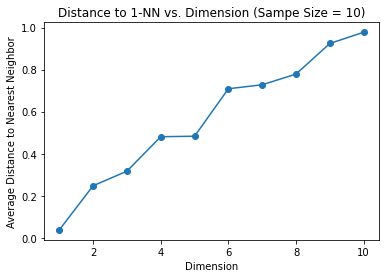

In [1]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
N = 10
ndist = np.zeros(10)
for p in range(10):
    X = np.random.uniform(low=0.0, high=1.0,size=[N,p+1])
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)  
    distances, indices = nbrs.kneighbors(X)
    ndist[p] = np.mean(distances[:,1])  # The first neighbor is the observation itself. The second neighbor is what we want.

plt.plot(range(1,11), ndist,'.-',markersize = 12)
plt.xlabel('Dimension')
plt.ylabel('Average Distance to Nearest Neighbor')
plt.title('Distance to 1-NN vs. Dimension (Sampe Size = 10)');

2) We now fix $p = 10$ and set $N$ as 10, 100, 1000, or 10000. The average distances to the nearest neighbor of all observations for different $N$ are shown in the plot below. 

> We observe that when $N$ increases to 10000, the average distance for $p=10$ is around 0.4, which is still higher than the values of $p=1,2,3$ with $N = 10$. This shows that decreasing the number of features is more effective than increasing the number of samples to solve the curse of high dimensionality. 


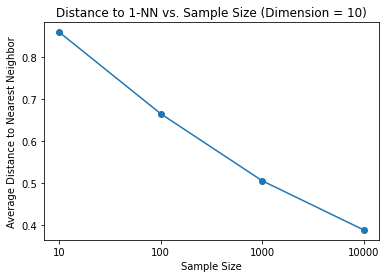

In [2]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0) # fix random seed
N = 10
p = 10
ndist2 = np.zeros(4)
for Np in range(4):
    X = np.random.uniform(low=0.0, high=1.0,size=[N**(Np+1),p])
    nbrs2 = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
    distances2, indices2 = nbrs2.kneighbors(X)
    ndist2[Np] = np.mean(distances2[:,1])

plt.plot(range(1,5), ndist2,'.-',markersize = 12)
plt.xticks(range(1,5), (10,100,1000,10000))
plt.xlabel('Sample Size')
plt.ylabel('Average Distance to Nearest Neighbor')
plt.title('Distance to 1-NN vs. Sample Size (Dimension = 10)');

### Principal Component Analysis (PCA)
#### Methodology of PCA

**Principal Component Analysis (PCA)** identifies the linear combinations of features that account for **the most variance** in the data. These linear combinations are called the Principal Components (PCs). PCA is one of the most popular linear dimensionality reduction methods.

> **Definition (Linear Dimensionality Reduction)** Give a $d$-dimensional feature vector $\mathbf{x} \in \mathbb{R}^{d}$ and a choice of dimensionality $r < d$. An linear transformation $f: \mathbb{R}^d \rightarrow \mathbb{R}^r$ can be represented by a transformation matrix $\mathbf{V} \in \mathbb{R}^{d\times r}$ that $\mathbf{y} = f(\mathbf{x}) =  \mathbf{V}^T\mathbf{x} $, where $\mathbf{y} \in \mathbb{R}^{r}$ is called  the transformed feature vector.

Denote the $N$ observations of $\mathbf{x}$ by $\mathbf{x}^1, \mathbf{x}^2, \dots, \mathbf{x}^N$, and $\mathbf{X} = (\mathbf{x}^1, \mathbf{x}^2, \dots, \mathbf{x}^N)^T \in \mathbb{R}^{N\times d}$ is the data matrix. Then the transformed data with linear transformation $f$ will be $\mathbf{Y} = \mathbf{X}\mathbf{V} \in \mathbb{R}^{N\times r}$.

To begin with, we consider to generate only one feature with $r=1$.
Then, $\mathbf{V}$ becomes a transformation vector (denoted by $\mathbf{v}$), and the transformed $N \times 1$ data is $\mathbf{y}_1 = \mathbf{X}\mathbf{v}$. 

The first step of PCA is to center each column 
of $\mathbf{X}$ to make sure that $\mathbf{1}^T\mathbf{X} = \sum_{i=1}^N (\mathbf{x}^{i})^T = \mathbf{0}^T$. As a result, the sample mean of the transformed feature is also 0 since $\frac{1}{N}\mathbf{1}^T\mathbf{y}_1 = \frac{1}{N}\mathbf{1}^T\mathbf{X}\mathbf{v} = \frac{1}{N}\mathbf{0}^T\mathbf{v} = 0$. 

PCA then finds $\mathbf{v}$ which maximizes the sample variance of the transformed feature:
> $\max_{\mathbf{v}} \mathbf{y}_1^T\mathbf{y}_1 = \max_{\mathbf{v}} \mathbf{v}^T\mathbf{X}^T\mathbf{X}\mathbf{v}$ subject to $\mathbf{v}^T\mathbf{v} = 1$,

where $\mathbf{v}^T\mathbf{v} = 1$ is used to control the scale of $\mathbf{v}$. The solution of the above optimization problem is denoted as $\mathbf{v}_1$. Then the transformed feature $\mathbf{y}_1 = \mathbf{X}\mathbf{v}_1$ is called the first PC of $\mathbf{X}$.

Now we consider the case when $r>1$. After $\mathbf{v}_1$ and $\mathbf{y}_1$ are obtained, we can find the next PC (the next transformed feature) $\mathbf{y}_2 = \mathbf{X}\mathbf{v}_2$ where $\mathbf{v}_2$ is the solution of:

> $\max_{\mathbf{v}} \mathbf{v}^T\mathbf{X}^T\mathbf{X}\mathbf{v}$ subject to $\mathbf{v}^T\mathbf{v} = 1$ and $\mathbf{v}^T\mathbf{v}_1 = 0$.

where $\mathbf{v}^T\mathbf{v}_1 = 0$ requires that the new $\mathbf{v}$ should be orthogonal to $\mathbf{v}_1$. 

In the similar way, we can solve $\mathbf{v}_3,\dots,\mathbf{v}_r$ sequantially with the additional constraint that when solving $\mathbf{v}_i$ ($i = 3,\dots r$), $\mathbf{v}_i$ should be orthogonal to $\mathbf{v}_1,\dots,\mathbf{v}_{i-1}$. Then the transformation matrix is $\mathbf{V} = (\mathbf{v}_1, \mathbf{v}_2,\dots, \mathbf{v}_r$). The transformed data is $\mathbf{Y} = \mathbf{X}\mathbf{V}$ which contains the first $r$ PCs of the original data. At most, we can generate $r = \text{rank}(\mathbf{X})$ PCs.

#### PCA is related to the **singular value decomposition (SVD)**.

The SVD is a matrix factorization/decomposition method. Specifically, the SVD of an $ N\times p$ real matrix $\mathbf{X}$ is a factorization of the form:

> $\mathbf{X} = \mathbf{U}\boldsymbol{\Sigma}\mathbf{V}^T$.

* $\mathbf{U} \in \mathbb{R}^{N \times N}$ and $\mathbf{V} \in \mathbb{R}^{p \times p}$ are orthogonal matrices that $\mathbf{U}^T\mathbf{U} = \mathbf{U}\mathbf{U}^T = \mathbf{I}$ and $\mathbf{V}^T\mathbf{V} = \mathbf{V}\mathbf{V}^T = \mathbf{I}$
* $\boldsymbol{\Sigma} \in \mathbb{R}^{N \times p}$ is a rectangular diagonal matrix with non-negative real numbers on the diagonal. The diagonal entries $\sigma_i = \Sigma_{ii}$ are known as the singular values of $\mathbf{X}$. 
* The columns of $\mathbf{U}$ and the columns of $\mathbf{V}$ are called the left-singular vectors and right-singular vectors of $\mathbf{X}$, respectively.

There are several properties:

(1) **The solution of $\mathbf{v}_i$ when constructing the $i$th PC is the same as the right-singular vector of $\mathbf{X}$ corresponding to the $i$th largest singular value.** As a result, PCA can be solved by the SVD.

(2) The sample variance of the $i$th PC is $\mathbf{y}_i^T\mathbf{y}_i = \sigma_i^2$. Then $\frac{\sigma_i^2}{\sum_{i=1}^N \sigma_i^2} = \frac{ \mathbf{y}_i^T\mathbf{y}_i}{\sum_{i=1}^N\mathbf{y}_i^T\mathbf{y}_i} = \frac{\mathbf{y}_i^T\mathbf{y}}{\sum_{i=1}^N\mathbf{x}_i^T\mathbf{x}_i}$ is called the percentage of variance explained by the $i$th PC. $\mathbf{x}_i$ here represents the centered $\mathbf{x}_i$. $\frac{\sum_{i=1}^r\sigma_i^2}{\sum_{i=1}^N \sigma_i^2}$ is called the percentage of variance explained by the first $r$ PCs.

(3) For any two PCs $\mathbf{y}_i$ and $\mathbf{y}_j$ with $i \neq j$, $\mathbf{y}_i^T\mathbf{y}_j = 0$. This means that every two PCs are orthogonal to each other.

> Proof: $\mathbf{y}_i = \mathbf{X}\mathbf{v}_i = \mathbf{U}\boldsymbol{\Sigma}\mathbf{V}^T\mathbf{v}_i = \mathbf{U}\boldsymbol{\Sigma} \mathbf{e}_i^T = \sigma_{i}\mathbf{u}_i$, where $\mathbf{e}_i$ is the basis vector with the $i$th entry equal to 1 and the other entries equal to 0. Then $\mathbf{y}_i^T\mathbf{y}_j = \sigma_{i}\sigma_{j}\mathbf{u}_i^T\mathbf{u}_j = 0$.

#### Example 1: Iris dataset

The Iris dataset in sklearn.datasets represents 3 kinds of Iris flowers (Setosa, Versicolour, and Virginica) with 4 attributes: sepal length, sepal width, petal length, and petal width. Here we plot different observations on the first 2 principal components. The color of each point in the plot reflects its kind.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA

iris = datasets.load_iris()
X = iris.data # 4 columns, each column for one feature.
y = iris.target
target_names = iris.target_names

## run PCA with 2 components
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

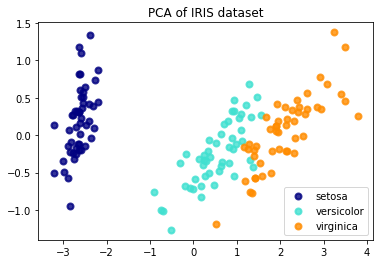

<Figure size 432x288 with 0 Axes>

In [4]:
plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure();

#### Example 2: Labeled Faces

The Wild dataset includes several thousand collated photos of various public figures, and we use the Labeled Faces figures as an example.

In [5]:
from sklearn.datasets import fetch_lfw_people
import numpy as np
import matplotlib.pyplot as plt
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


We first take a look at some figures.

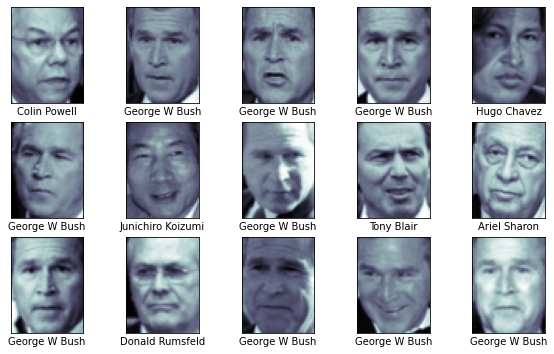

In [6]:
fig, ax = plt.subplots(3, 5,figsize=(10,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels. We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use PCA to extract 150 fundamental components.

Because this is a large dataset, we will use RandomizedPCA (svd_solver='randomized')—it contains a randomized method to approximate the first $N$ principal components much more quickly than the standard PCA estimator, and thus is very useful for high-dimensional data (here, a dimensionality of nearly 3,000). 


Note that the default selection of "svd_solver" is 'auto'. When the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ‘randomized’ method is enabled automatically for this default selection. (For more information, see: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html.)

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=150, svd_solver='randomized')
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='randomized', tol=0.0, whiten=False)

In this case, it can be interesting to visualize the images associated with the first several principal components (these components are technically known as "eigenvectors," so these types of images are often called "eigenfaces"). As you can see in this figure, they are as creepy as they sound:

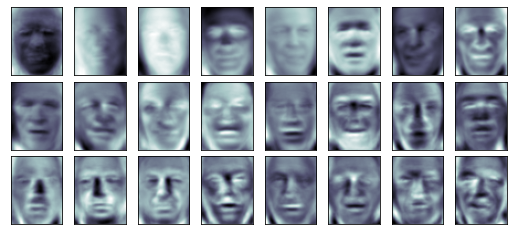

In [8]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

The results are very interesting, and give us insight into how the images vary.

* the first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face.
* later principal vectors seem to be picking out certain features, such as eyes, noses, and lips. 



Let's take a look at the cumulative variance of these components to see how much of the data information the projection is preserving. We see that these 100 components account for 91.55% of the variance. That would lead us to believe that using these 100 components, we would recover most of the essential characteristics of the data.

0.9155196

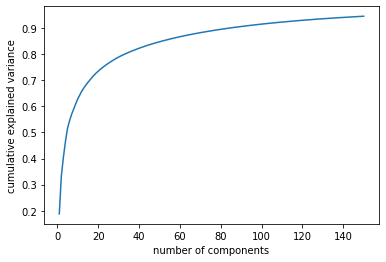

In [9]:
plt.plot(range(1,151), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
np.cumsum(pca.explained_variance_ratio_)[99]

### Limitation of the linear dimensionality reduction

We use the following example to show the limitation of the linear dimensionality reduction:

The Swiss Roll data includes three features, which is usually generated by

> $x = \phi cos(\phi)$  
> $y = \phi csin(\phi)$  
> $z = \psi$  

Each point in the swiss roll data can be represented by two features $(\phi,\psi)$. We construct a Swiss Roll dataset with 3000 points and plot it below. The shape of the Swiss Roll data looks like a swiss roll in 3D scatter plot. The color of a point shows its $\phi$.



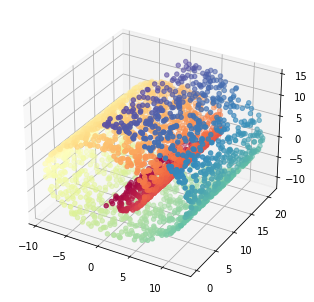

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

np.random.seed(0) # fix random seed
# Generate a Swiss Roll with 3000 samples
X, color = datasets.make_swiss_roll(n_samples=3000) 

# Plot the Swiss Roll
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
plt.show()

Suppose that in the Swiss Roll data, $\phi$ is the most important feature in machine learning tasks. For example, points with more similar $\phi$ are more likely to come from the same group in a classifciation or clustering problem, or a response variable is highly linearly correlated with $\phi$ in a regression problem. Then we hope that we could recover $\phi$ by dimensionality reduction methods. Since we know that the relationship between the oriignal features and $\phi$ are not linear, the linear dimensionality recution methods such as PCA does not work.

For example, we construct the first 2 PCs from the Swiss Roll dataset.

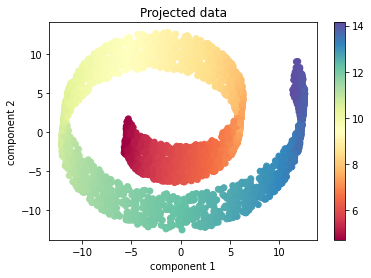

In [11]:
pca = PCA(n_components=2)  # project from 64 to 2 dimensions
Y_projected = pca.fit_transform(X)

plt.scatter(Y_projected[:, 0], Y_projected[:, 1],
            c=color, cmap=plt.cm.Spectral)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.title('Projected data');

We can see that PCA still keeps the global shape of the Swiss Roll dataset and cannot discover $\phi$. As a result, we now introduce three non-linear dimensionality reduction methods that focus more on the local information of data than the global information of data.



### T-SNE

The idea of T-SNE is to convert affinities/closeness of data points to probabilities. It assumes that 
> $P_1$(The edge between $i$ and $j$ are selected in the original feature space in an edge sampling process) $\approx P_2$(The edge between $i$ and $j$ are selected in the projection space in an edge sampling process)

Both $P_1 = f_1(\text{closeness}(\mathbf{x}^i,\mathbf{x}^j))$ and $P_2 = f_2(\text{closeness}(\mathbf{y}^i,\mathbf{y}^j))$ are functions of the closeness of data points but have different forms. $f_1$ is built from the Gaussian distribution, while $f_2$ is built from the Student’s t-distribution. Finally, $KL$ divergence (a measure of how one probability distribution is different from a second, reference probability distribution) is used to calculate the different between $P_1$ and $P_2$ on all edges. And $\mathbf{y}^i$s are generated by minimizing this $KL$ divergence.

Since t-distribution has a heavier tail than the Gaussian distribution,
the usage of t-distribution allows t-SNE to be particularly sensitive to local structure in the original feature space and has a few other advantages over existing techniques:
1. Reveal the structure at many scales on a single map;

2. Reveal data that lie in multiple, different, manifolds or clusters;

3. Reduce the tendency to crowd points together at the center.

### Example: Handwritten numbers dataset

Handwritten numbers dataset collects a group of images of the hand written numbers from 1 to 10. Each image fits in an 8$\times$8 pixel box, with the grey level of each pixel recorded in a 8$\times$8 data matrix. Every matrix is flattened into a vector of 64 numbers, so we have 64 features in this dataset.


We use this example to show that t-SNE gives better dimensionality reduction results than other methods when the number of projected features is small (usually 2 or 3). As a result, t-SNE is a popular method to visualize high-dimensional data.


We construct the two-dimensional projected features using PCA, and t-SNE respectively, and draw a scatter plot of images according to each of them.

In [12]:
import matplotlib.pyplot as plt
from sklearn import datasets

digits = datasets.load_digits()  ## load data

There are 1797 observations in this dataset.

In [13]:
from sklearn.decomposition import PCA
from sklearn import manifold

# PCA
pca = PCA(n_components=2)  
PCA_projected = pca.fit_transform(digits.data)

# TSNE
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
TSNE_projected = tsne.fit_transform(digits.data)

In the above code, we see that the 'init' parameter of TSNE is 'pca'. Usually, when we apply a nonlinear dimensionality reduction method, we first use PCA (or another linear dimensional reduction method) to reduce the method to a $r^*$-dimensional space that $r \leq r^* < d$. This step can help improve the performance of nonlinear dimensionality reduction methods and make more stable results. The reason comes from two aspects. First, the selected first $r^*$th PCs could contain most of the variance of the original data. The remaining part of variance usually contains a lot of noise and is not useful. Second, the PCs are orthogonal to each other, and using PCA can avoid multicollinearity in the original data.

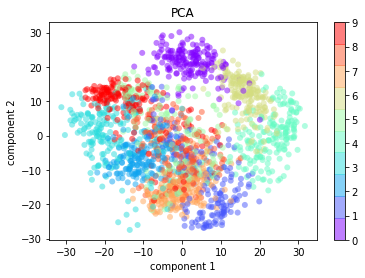

In [14]:
## draw plots
def draw_components(Y_projected, title):
    plt.scatter(Y_projected[:, 0], Y_projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('rainbow', 10))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.title(title)
    plt.colorbar();
draw_components(PCA_projected, 'PCA');

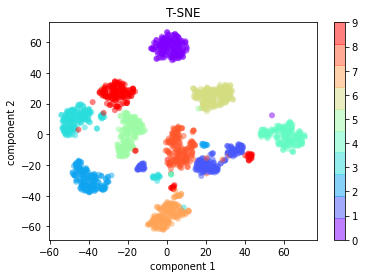

In [15]:
draw_components(TSNE_projected, 'T-SNE');

We observe that T-SNE can separate the images with different numbers best.

We now cluster all images into 10 groups and expect that each group contains one of numbers from 1 to 10. We compare the clustering results of k-means methods built on the original 64 features and the two-dimensional features constructed by different dimensionality reduction methods respectively. With the true labels of numbers, we use the ARI metric to evaluate their clustering results.

In [16]:
# For k-means with original features
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

# "random_state=100" is to set a random number.
cluster_ori = KMeans(n_clusters=10,random_state=100).fit_predict(digits.data)
cluster_PCA = KMeans(n_clusters=10,random_state=100).fit_predict(PCA_projected)
cluster_TSNE = KMeans(n_clusters=10,random_state=100).fit_predict(TSNE_projected)

# caluclate ARI of different mehtods
ari_ori = metrics.adjusted_rand_score(digits.target, cluster_ori)
ari_PCA = metrics.adjusted_rand_score(digits.target, cluster_PCA)
ari_TSNE = metrics.adjusted_rand_score(digits.target, cluster_TSNE)

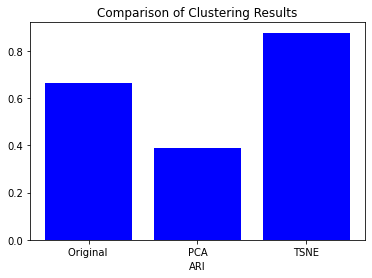

In [17]:
# Compare the results
name_list = ['Original ','PCA','TSNE']
num_list = [ari_ori,ari_PCA,ari_TSNE]
plt.bar(range(len(num_list)), num_list, color = "b",tick_label=name_list)
plt.xlabel("ARI")
plt.title("Comparison of Clustering Results");

We can see that for this dataset, TSNE performs much better than other methods in clustering the images.